In [19]:
# %matplotlib notebook
from IPython.display import display, IFrame, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy             as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib          import rc 
from matplotlib          import cm

import pandas as pd
import corner

import os
import os.path as path
import wget

import emcee

from tqdm import tqdm

from scipy.integrate import dblquad
from scipy.integrate import quad

In [20]:
# Descargamos data
if not path.exists('Data'):
    os.mkdir('Data')

!rm Data/*

file = 'Data/Gaussiana.csv'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/Gaussiano.csv'
#url = 'https://raw.githubusercontent.com/asegura4488/DataBase/main/MetodosComputacionales/Likelihood.dat'
if not path.exists(file):
    Path_ = wget.download(url,file)
    print('File loaded')
else:
    Path_ = file

100% [................................................................................] 1836 / 1836File loaded


In [27]:
data = pd.read_csv(Path_)
X = data.x

In [28]:
def LogPrior(p):
    
    mu, sigma = p
    
    if 3 <= mu <= 5. and 0.5 <= sigma <= 3.5:
        return 0.
    else:
        return -np.inf

In [29]:
def Gauss(p,x):
    
    mu, sigma = p
    
    return np.exp( -0.5*(x-mu)**2/sigma**2  )/np.sqrt(2*np.pi*sigma**2)

In [30]:
def Likelihood(p,x):
    return Gauss(p,x)

In [36]:
def JointLikelihood(p,x):
    return np.sum( np.log(Likelihood(p,x)) )

In [37]:
def LogPosterior(p,x):
    
    LogP = LogPrior(p)
    
    if not np.isfinite(LogP):
        return -np.inf
    else:
        return JointLikelihood(p,x) + LogP

In [38]:
n_walkers, n_params = 5, 2
p0 = np.zeros((n_walkers,n_params))
p0[:,0] = 2.
p0[:,1] = 2.
p0
p0 += np.random.rand(n_walkers,n_params)
p0

array([[2.58197   , 2.46359587],
       [2.686647  , 2.36958282],
       [2.71949683, 2.82282074],
       [2.37374345, 2.31580157],
       [2.73296522, 2.59729203]])

In [39]:
sampler = emcee.EnsembleSampler(n_walkers,n_params,LogPosterior,args=[X])

In [44]:
pos,prob,state = sampler.run_mcmc(p0,5000,progress=True)

100%|██████████████████████████████████████████████████████████| 5000/5000 [00:44<00:00, 111.27it/s]


Text(0.5, 0, 'step number')

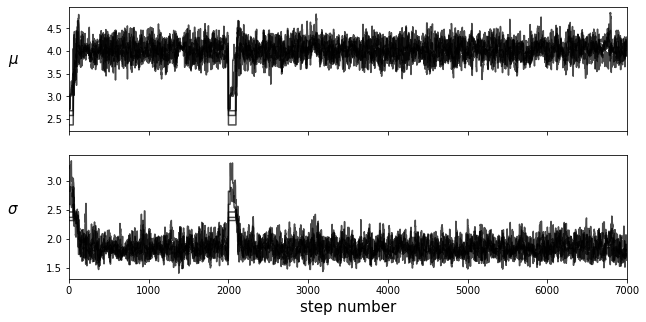

In [45]:
fig, axes = plt.subplots(n_params, figsize=(10, 5), sharex=True)

samples = sampler.get_chain()
labels = ["$\mu$","$\sigma$"]

for i in range(n_params):
    
    ax = axes[i]
    ax.plot(samples[:,:,i], "k", alpha=0.7)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0, fontsize=15)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number",fontsize=15)

In [46]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
truths = np.percentile(pos, 50, axis=0)

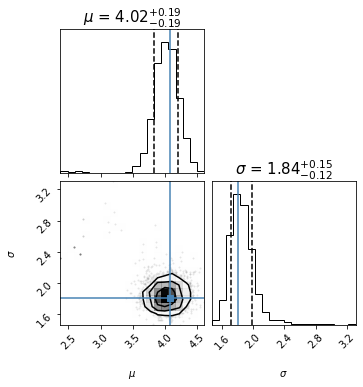

In [47]:
figure = corner.corner(flat_samples, 
                       truths=truths, 
                       labels=labels, 
                       quantiles=[0.16,0.84], 
                       show_titles=True,
                       title_kwargs={"fontsize":15})
